In [31]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
from torchinfo import summary
import seaborn as sns
import torch.nn as nn
from tqdm import tqdm
import numpy as np
import random
import torch

# 
torch.manual_seed(43)
np.random.seed(43)
random.seed(43)

# Configs

In [ ]:
BATCH_SIZE = 128
NUM_CLASSES = 10

transform_func = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize(mean=(0.1307,), std=(0.3080,)) # from prev comp mnist u=0.1307 std=0.3081
])


DEVICE = 'cpu'

if torch.mps.is_available(): DEVICE = 'mps'
elif torch.cuda.is_available(): DEVICE = 'cuda'

DEVICE

'mps'

# Data

## Train

In [3]:
# train data
train_data = MNIST(root='./data/', train=True, download=True, transform=transform_func)

NUM_CLASSES= np.unique(train_data.targets).__len__()

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True,)

print(
  f"""
  data samples: {train_loader.dataset.__len__()}
  number batch: {train_loader.__len__()}
"""
)



  data samples: 60000
  number batch: 469



torch.Size([28, 28]) 0


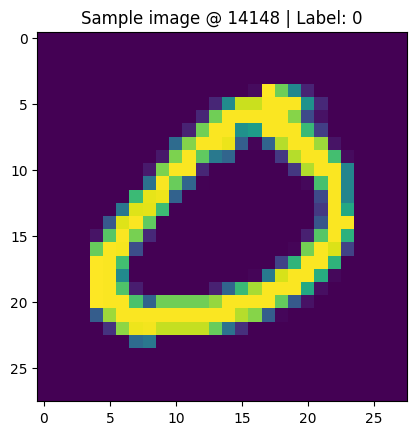

In [4]:
idx = np.random.randint(0, train_loader.dataset.__len__() )
img = train_data.data[idx]
img_label = train_data.targets[idx].item()

print(img.shape, img_label)

img = img.unsqueeze(0)
img = img.permute(1, 2, 0)
img.shape

plt.imshow(img)
plt.title(f"Sample image @ {idx} | Label: {img_label}")
plt.show()

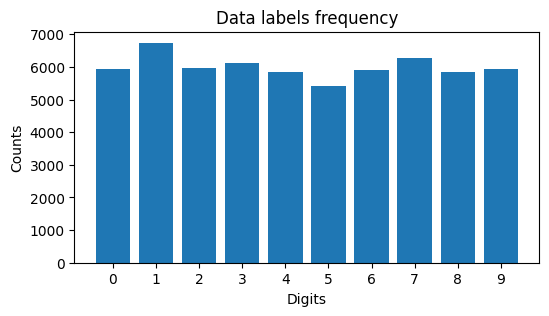

In [5]:
train_labels = train_data.targets
labels_counts = torch.bincount(train_labels)

labels = [str(i) for i in range(10)]

plt.figure(figsize=(6, 3))
plt.bar(labels, labels_counts.numpy())
plt.title("Data labels frequency")
plt.ylabel("Counts")
plt.xlabel("Digits")
plt.show()

## Test

In [6]:
# test data
test_data = MNIST('./data', train=False, download=True, transform=transform_func)
test_loader = DataLoader(test_data, batch_size=128)

print(
  f"""
  data samples: {test_loader.dataset.__len__()}
  number batch: {test_loader.__len__()}
"""
)


  data samples: 10000
  number batch: 79



# Model

In [ ]:
class Model(nn.Module):
  def __init__(self, num_classes, in_channels = 1 ):
    super().__init__()
    
    self.kernel = 3
    self.in_channels = in_channels
    self.num_classes = num_classes

    self.conv1 = nn.Sequential(
      nn.Conv2d(1, 64, kernel_size=self.kernel, padding= self.pad()),
      # nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.MaxPool2d(2, 2),
    )

    self.avg_pool = nn.AdaptiveAvgPool2d((1, 1)) # [B, prev_conv_out, 1, 1]
 
    self.l1 = nn.Linear(64, 64)
    self.dropout = nn.Dropout(.4)

    self.out = nn.Linear(64, self.num_classes)

  def pad(self):
    return int( (self.kernel - 1) // 2)

  def forward(self, x):
    x = self.conv1( x )

    x = self.avg_pool( x )

    x = x.view( x.size(0), -1 )

    x = self.dropout( self.l1( x ) )

    return self.out(x)

model = Model(num_classes=NUM_CLASSES)

model.to(DEVICE)

print(
  "Number of params:", 
  sum([p.numel() for p in model.parameters()])
)

# model

Number of parameters: 5450


In [8]:
summary(model, (1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Model                                    [1, 10]                   --
├─Sequential: 1-1                        [1, 64, 14, 14]           --
│    └─Conv2d: 2-1                       [1, 64, 28, 28]           640
│    └─ReLU: 2-2                         [1, 64, 28, 28]           --
│    └─MaxPool2d: 2-3                    [1, 64, 14, 14]           --
├─AdaptiveAvgPool2d: 1-2                 [1, 64, 1, 1]             --
├─Linear: 1-3                            [1, 64]                   4,160
├─Dropout: 1-4                           [1, 64]                   --
├─Linear: 1-5                            [1, 10]                   650
Total params: 5,450
Trainable params: 5,450
Non-trainable params: 0
Total mult-adds (M): 0.51
Input size (MB): 0.00
Forward/backward pass size (MB): 0.40
Params size (MB): 0.02
Estimated Total Size (MB): 0.43

# Loss - Optim

In [9]:
optimizer = torch.optim.AdamW(
  model.parameters(), 
  lr=1e-3,
  weight_decay=1e-4
)

loss_func = nn.CrossEntropyLoss()

# lr sheduler
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)

# Train

In [10]:
DEVICE

'mps'

In [ ]:
model.to(DEVICE)

epochs = 200

train_losses = list()
train_acc = list()

for epoch in range(epochs):

  model.train()

  epoch_loss = 0
  epoch_acc = 0
  train_total = 0

  for batch in tqdm(train_loader, desc=f"Train [{epoch+1}/{epochs}] ... "):

    optimizer.zero_grad()

    images, labels = batch
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    outputs = model(images)

    loss = loss_func(outputs, labels)

    loss.backward()
    optimizer.step()

    # metrics
    epoch_loss += loss.item() * labels.size(0)

    acc = torch.argmax(outputs, dim=1)
    epoch_acc += (acc == labels).sum().item()

    train_total += labels.size(0)

  # evaluate

  # metrics
  # 
  el = epoch_loss / train_total
  ea = epoch_acc / train_total

  train_losses.append(el)
  train_acc.append(ea)

  print(f"Epoch: {epoch+1}/{epochs} | loss: {el:.4f} | acc: {ea:.4f} \n")

# Learning Curve

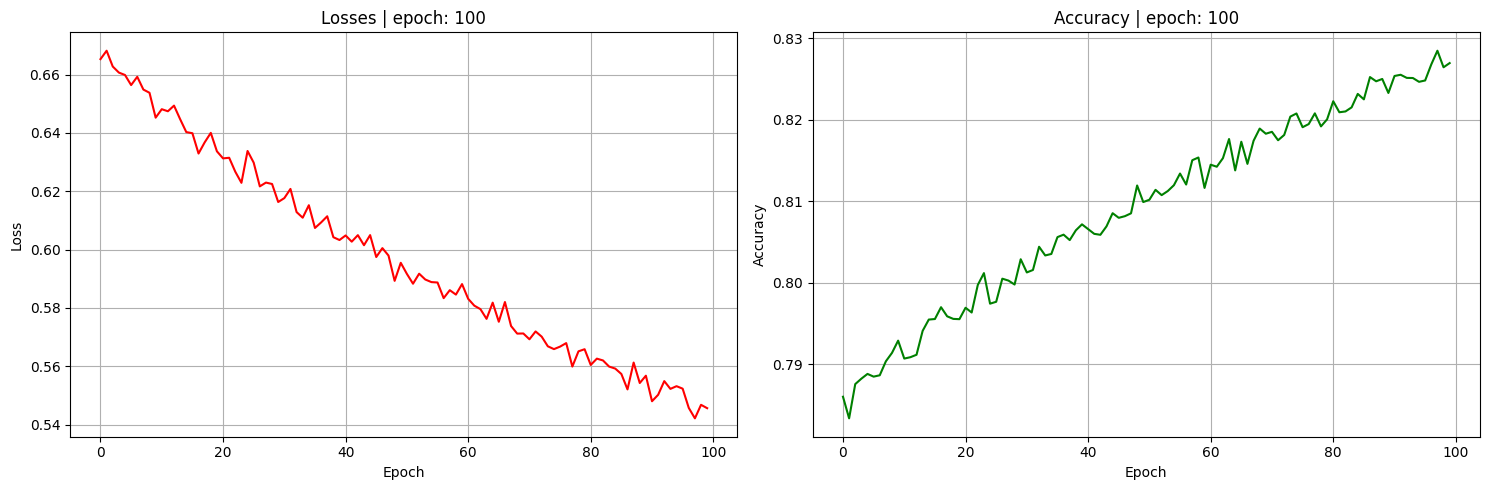

In [15]:
plt.figure(figsize=(15, 5))


plt.subplot(1, 2, 1)
plt.plot(train_losses, color='red', label='Train loss')
plt.title(f"Losses | epoch: {epochs}")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(train_acc, color='green', label='Train acc')
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.title(f"Accuracy | epoch: {epochs}")
plt.grid()

plt.tight_layout()
plt.show()

# Test

In [35]:
model.eval()

true_labels = list()
pred_labels = list()
pred_probs = list()
test_loss = 0
total_samples = 0

with torch.no_grad():

  for test_batch in tqdm(test_loader, desc="Evaluating model ... "):
    images, labels = test_batch
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    outputs = model(images)

    preds = torch.argmax(outputs, dim=1)

    # loss
    loss = loss_func(outputs, labels)
    test_loss += loss.item() * images.size(0)
    total_samples += images.size(0)

    true_labels.extend(labels.cpu().numpy())
    pred_labels.extend(preds.cpu().numpy())
    pred_probs.append( nn.functional.softmax(outputs, dim=1).cpu().numpy() ) # wanna get probs of each class, for roc-auc

true_labels = np.array(true_labels)
pred_labels = np.array(pred_labels)
avg_test_loss = test_loss / total_samples
pred_probs = np.vstack(pred_probs)

roc_auc = roc_auc_score(true_labels, pred_probs, multi_class='ovr', average='macro')

Evaluating model ... : 100%|██████████| 79/79 [00:00<00:00, 102.65it/s]


In [37]:
print(
  f"""ROC-AUC : {roc_auc:.4f}
"""
)

print(
  classification_report(
    true_labels, pred_labels, zero_division=1
  )
)

ROC-AUC : 0.9852

              precision    recall  f1-score   support

           0       0.89      0.86      0.87       980
           1       0.96      0.98      0.97      1135
           2       0.79      0.62      0.70      1032
           3       0.86      0.92      0.89      1010
           4       0.87      0.92      0.89       982
           5       0.74      0.87      0.80       892
           6       0.77      0.80      0.78       958
           7       0.93      0.88      0.91      1028
           8       0.87      0.83      0.85       974
           9       0.83      0.84      0.83      1009

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



## Confusion matrix

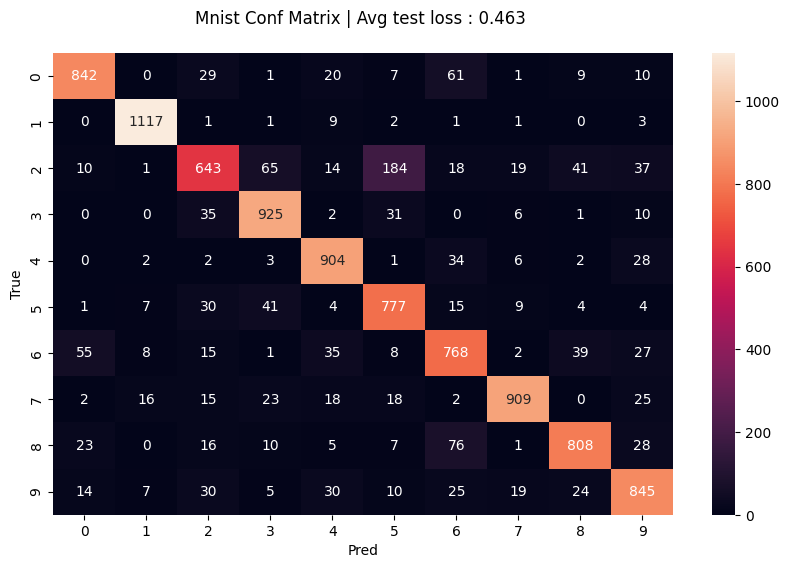

In [38]:
conf = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(10, 6))
sns.heatmap(conf, annot=True, fmt='d')
plt.xlabel("Pred")
plt.ylabel("True")
plt.title(f"Mnist Conf Matrix | Avg test loss : {avg_test_loss:.3f} \n")
plt.show()

## Receiver operating characteristic - Area under curve
- one vs rest .. because this is multi-class .. to be able to tell, how the model is able to distinguish between the 10 different classes .. from the graph the model is doing well .. line from (0,0) to (1,1) tells that the model is not able to distinguish between false positive rate and true positive rate, but from the graph below the model is well and can distinguish between classes : true positive rate != false positive rate

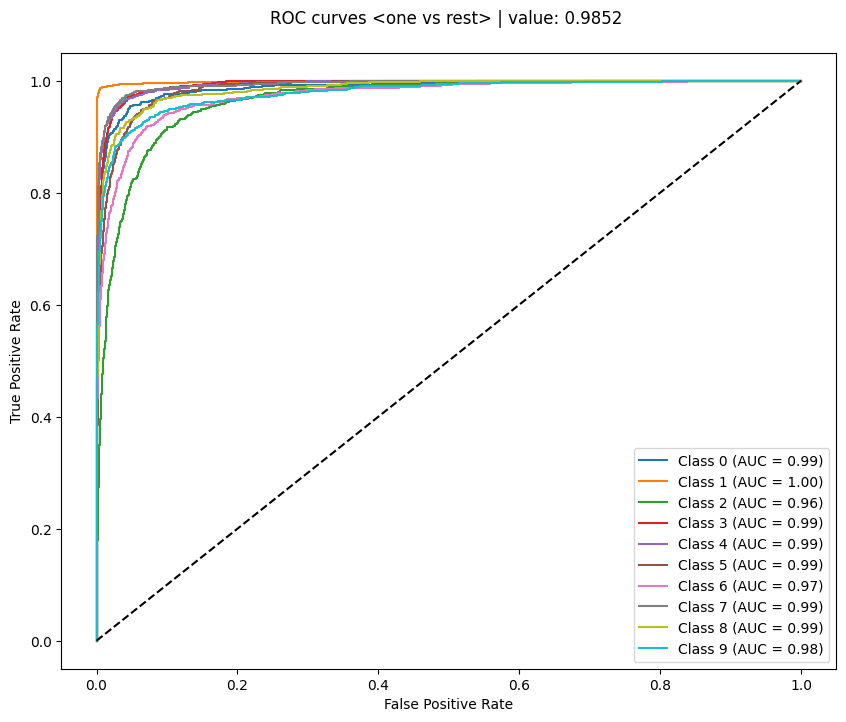

In [44]:


plt.figure(figsize=(10, 8))
for class_ in range(NUM_CLASSES):
  fpr, tpr, _ = roc_curve(true_labels == class_, pred_probs[:, class_])
  plt.plot(fpr, tpr, label=f'Class {class_} (AUC = {roc_auc_score(true_labels == class_, pred_probs[:, class_]):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC curves <one vs rest> | value: {roc_auc:.4f} \n')
plt.legend()
plt.show()